# 3 - Modelagem

Concluída a fase de exploração de dados, vamos agora modelá-los usando os padrões descobertos.

Nessa fase, buscaremos construir um modelo que, baseado nas variáveis contidas na base de dados de COVID, prediga o resultado de um teste para COVID.

In [15]:
# para carregar a base de dadas limpa
import pickle
from typing import Tuple

import numpy as np
import pandas as pd
from scipy import stats as spst
from tqdm import tqdm

# gráficos
import seaborn as sns
from matplotlib import rcParams, pyplot as plt

# parâmetros do matplotlib
# essencialmente, para deixar os gráficos maiores por padrão
rcParams['figure.dpi'] = 120
rcParams['figure.figsize'] = (10, 8)

# warnings
import warnings
warnings.filterwarnings("ignore")

# pacote com funções para análise desse projeto
import os
cwd = os.getcwd()
os.chdir("../")
import scripts.plots as splt, scripts.metrics as smetrics
os.chdir(cwd)

## Importação e checagem de integridade

Vamos importar os dados limpos e verificar a integridade dos mesmos.

In [16]:
with open(r'../data/covid_limpo.df', 'rb') as covidfile:
    pickler = pickle.Unpickler(file = covidfile)
    covid_full = pickler.load()

In [17]:
covid_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 496285 entries, 0 to 499691
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   sex                  496285 non-null  category
 1   patient_type         496285 non-null  category
 2   pneumonia            496285 non-null  category
 3   age                  496285 non-null  int8    
 4   diabetes             496285 non-null  category
 5   copd                 496285 non-null  category
 6   asthma               496285 non-null  category
 7   inmsupr              496285 non-null  category
 8   hypertension         496285 non-null  category
 9   other_disease        496285 non-null  category
 10  cardiovascular       496285 non-null  category
 11  obesity              496285 non-null  category
 12  renal_chronic        496285 non-null  category
 13  tobacco              496285 non-null  category
 14  contact_other_covid  343718 non-null  category
 15  

In [18]:
covid_full.head()

,sex,patient_type,pneumonia,age,diabetes,copd,asthma,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res
id,,,,,,,,,,,,,,,,
0,0,1,0,27,0,0,0,0,0,0,0,0,0,0,0,1
1,0,1,0,24,0,0,0,0,0,0,0,0,0,0,NaN,1
2,1,0,0,54,0,0,0,0,0,0,0,1,0,0,NaN,1
3,0,0,1,30,0,0,0,0,0,0,0,0,0,0,NaN,1
4,1,0,0,60,1,0,0,0,1,0,1,0,0,0,NaN,1


In [19]:
covid_full.covid_res.value_counts(normalize = True)

0    0.558919
1    0.441081
Name: covid_res, dtype: float64

## Construção dos possíveis modelos

Vamos construir os possíveis modelos, para então compará-los.

Cada modelo será um `Pipeline` onde entra a base de treino (`X_train`, `y_train`) e sai uma probabilidade de classificação. Para cada modelo, construiremos os passos dessa `Pipeline`.

### 0. Undersample

Como a base é muito grande, os modelos demoram baste para serem treinados. Logo, para a investigação de qual modelo é melhor, vamos tomar 50.000 registros do modelo aleatoriamente (a base de dados completa tem por volta de 500.000). Dessa forma, aceleramos a investigação sem perdermos muita potência estatística.

In [20]:
n_samples = 50_000
covid = covid_full.sample(n_samples)

### 1. Tratamento dos dados faltantes

Como falamos na seção de análise exploratória dos dados, tínhamos três opções para tratamento dos dados faltantes no campo `contact_other_covid`:

1. Remover os registros correspondentes;
2. Codificar os dados faltantes como uma nova categoria; ou
3. Remover o campo da análise.

Vamos agora implementar os três processadores.

In [21]:
from sklearn.model_selection import train_test_split
# função para separar bases diferentes em treino e teste

def train_test_split_base(
    base: pd.DataFrame,
    test_size: float,
    target: str,
    stratify: bool = True
) -> Tuple:
    
    base = base.copy()

    X = base.drop(columns = [target])
    y = base[target]

    if stratify:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            test_size = test_size,
            stratify = y,     # não é estritamente necessário pois a base é razoavelmente balanceada
        )
    
    else:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            test_size = test_size,
        )

    return base, (X_train, X_test, y_train, y_test)

In [22]:
bases = {}
tts_tuples = {}   # train test split
test_size = 0.4


#### 1. Remover os registros correspondentes

In [23]:
alternativa = 'contact_dropna'

bases[alternativa], tts_tuples[alternativa] = train_test_split_base(
    base = covid.dropna(),
    test_size = test_size,
    target = 'covid_res',
    stratify = True,
)

#### 2. Codificar os dados faltantes como uma nova categoria

In [24]:
alternativa = 'contact_nacat'

base = covid.copy()
base['contact_other_covid'] = base['contact_other_covid'].cat.codes.astype('category')

bases[alternativa], tts_tuples[alternativa] = train_test_split_base(
    base = base,
    test_size = test_size,
    target = 'covid_res',
    stratify = True,
)

#### 3. Eliminar o campo `contact_other_covid` da análise

In [25]:
# vamos eliminar essa alternativa por enquanto

# alternativa = 'contact_drop'

# bases[alternativa], tts_tuples[alternativa] = train_test_split_base(
#     base = covid.drop(columns = 'contact_other_covid'),
#     test_size = test_size,
#     target = 'covid_res',
#     stratify = True,
# )

### Modelo

Vamos agora construir os `Pipelines` com os modelos.

Primeiramente, vamos construir as partes comuns a todos os modelos:

1. Colunas numéricas: `age`. Para esta, usaremos o `StandardScaler` para normalizar os dados.

In [26]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# pipeline das colunas numéricas
pipeline_numericas = Pipeline(steps = [
    ('scaler_std', StandardScaler()),
])

2. Colunas categóricas: `sex`, `patient_type`, `pneumonia`, `diabetes`, `copd`, `asthma`, `inmsupr`, `hypertension`, `other_diseases`, `cardiovascular`, `obesity`, `renal_chronic`, `tobacco` e `contact_other_covid`. Para essas usaremos o `OneHotEncoder` para tratar antes de enviar ao modelo.

In [27]:
# pipeline das colunas categoricas
pipeline_categoricas = Pipeline( steps = [
    ('onehot', OneHotEncoder(handle_unknown = 'ignore')),
])

Vamos agora juntar todos em um passo só através do `ColumnTransformer`:

In [29]:
from sklearn.compose import ColumnTransformer

# nome das colunas numericas e categoricas
features_numericas = tts_tuples['contact_nacat'][0].select_dtypes(exclude = ['object', 'category']).columns
features_categoricas = tts_tuples['contact_nacat'][0].select_dtypes(include = ['object', 'category']).columns

# separador: os dados entram no pipeline e são separados em dois, cada um vai em um pipeline diferente
separador = ColumnTransformer(transformers = [
    ('numericas', pipeline_numericas, features_numericas),
    ('categoricas', pipeline_categoricas, features_categoricas)
])

# esse é o pipeline antes da aplicação do modelo final
steps_before_classifier = [ 
    ('separador', separador)
]

Por fim, vamos construir automaticamente os modelos.

Para cada alternativa para o campo `contact_other_covid`, vamos gerar um `Pipeline` com os modelos

* KNN;
* Regressão Logística;
* Árvore de Decisão;
* XGBoost; e
* Random Forests,

para então treiná-los.

In [45]:
# modelos
from sklearn.neighbors import KNeighborsClassifier as KNNClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from copy import deepcopy

# para que a cada rodada os valores permaneçam os mesmos
random_seed = 42

def assemble_pipeline(
    steps_before_classifier: list,
    model_name: str, 
    model,
    train_test_split_tuple: tuple,
    pipeline_class = Pipeline,
) -> Pipeline:

    X_train, X_test, y_train, y_test = train_test_split_tuple

    # ... montar os passos do pipeline final de cada modelo ...
    steps_final = steps_before_classifier + [ (model_name, model) ]

    # ... e criar a pipeline, fit, predict, predict_proba
    model = deepcopy(pipeline_class(steps = steps_final))
    model.fit(
        X_train,
        y_train
    )

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)

    # retornar a Pipeline completa, as predições com threshold 50% e as probabilidades
    return model, y_pred, y_prob


In [46]:
%%time
# GO!

# armazenamento dos classificadores, predições, probabilidades e tuplas tts
clfs = {}
y_preds = {}
y_probs = {}
train_test_splits = {}

# para cada estratégia de pre-processamento...
for preproc_name in bases.keys():
    # ... para cada modelo...
    for model_name, model in zip(
        ['knn', 'logistic', 'decision_tree', 'random_forest', 'xgboost'],
        [
            KNNClassifier(), 
            LogisticRegression(random_state = random_seed), 
            DecisionTreeClassifier(random_state = random_seed), 
            RandomForestClassifier(random_state = random_seed), 
            XGBClassifier(random_state = random_seed, eval_metric = 'logloss')
    ]):
        print(f"Trabalhando com estratégia de preproc '{preproc_name}' e modelo '{model_name}'... ", end = '')

        clf, y_pred, y_prob = assemble_pipeline(
            steps_before_classifier = steps_before_classifier,
            model_name = model_name, 
            model = model,
            train_test_split_tuple = tts_tuples[preproc_name]
        )

        nome_final = f'{preproc_name}__{model_name}'

        train_test_splits[nome_final] = tts_tuples[preproc_name]
        clfs[nome_final] = clf
        y_preds[nome_final] = y_pred
        y_probs[nome_final] = y_prob

        print('OK.')

Trabalhando com estratégia de preproc 'contact_dropna' e modelo 'knn'... OK.
Trabalhando com estratégia de preproc 'contact_dropna' e modelo 'logistic'... OK.
Trabalhando com estratégia de preproc 'contact_dropna' e modelo 'decision_tree'... OK.
Trabalhando com estratégia de preproc 'contact_dropna' e modelo 'random_forest'... OK.
Trabalhando com estratégia de preproc 'contact_dropna' e modelo 'xgboost'... OK.
Trabalhando com estratégia de preproc 'contact_nacat' e modelo 'knn'... OK.
Trabalhando com estratégia de preproc 'contact_nacat' e modelo 'logistic'... OK.
Trabalhando com estratégia de preproc 'contact_nacat' e modelo 'decision_tree'... OK.
Trabalhando com estratégia de preproc 'contact_nacat' e modelo 'random_forest'... OK.
Trabalhando com estratégia de preproc 'contact_nacat' e modelo 'xgboost'... OK.
Wall time: 30.5 s


## Avaliação dos modelos construídos

### Construção do *classification report*

Vamos chamar a função `classification_report` para ter um resumo das principais métricas de cada um dos 15 modelos fitados.

In [47]:
from sklearn.metrics import classification_report

# para cada modelo...
for (full_name, clf), y_pred, y_prob, tts in zip(
    clfs.items(), y_preds.values(), y_probs.values(), train_test_splits.values()
):
    y_test = tts[3]
    preproc_name, model_name = full_name.split('__')
    # plotar o clf report
    print('---------')
    print(f"Modelo: '{model_name}' (preproc: '{preproc_name}')")
    print('--> ')
    print(classification_report(
        y_true = y_test,
        y_pred = y_pred
    ))

---------
Modelo: 'knn' (preproc: 'contact_dropna')
--> 
              precision    recall  f1-score   support

           0       0.64      0.71      0.67      8251
           1       0.49      0.42      0.45      5577

    accuracy                           0.59     13828
   macro avg       0.57      0.56      0.56     13828
weighted avg       0.58      0.59      0.58     13828

---------
Modelo: 'logistic' (preproc: 'contact_dropna')
--> 
              precision    recall  f1-score   support

           0       0.64      0.91      0.75      8251
           1       0.65      0.25      0.36      5577

    accuracy                           0.64     13828
   macro avg       0.64      0.58      0.56     13828
weighted avg       0.64      0.64      0.60     13828

---------
Modelo: 'decision_tree' (preproc: 'contact_dropna')
--> 
              precision    recall  f1-score   support

           0       0.63      0.85      0.73      8251
           1       0.55      0.26      0.36      55

### Curva ROC

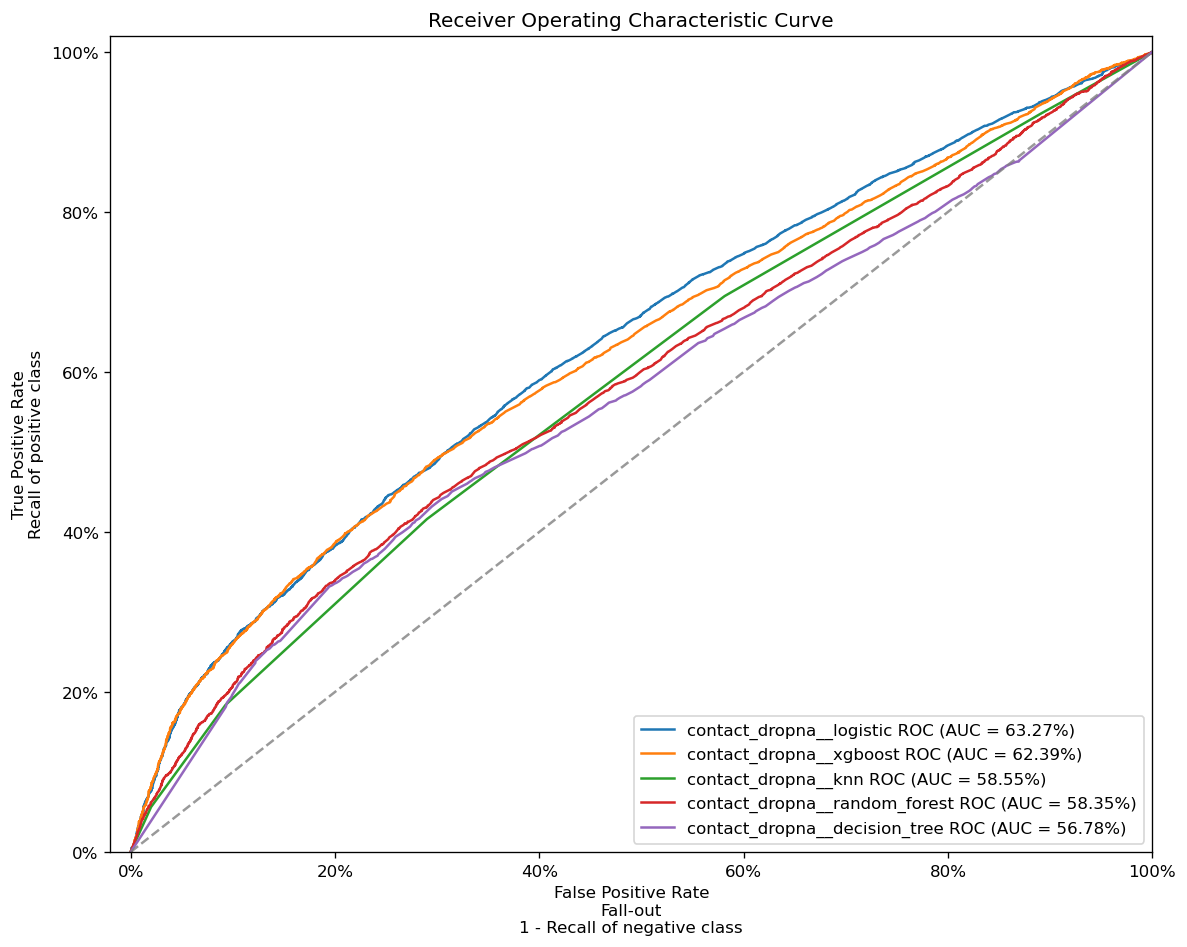

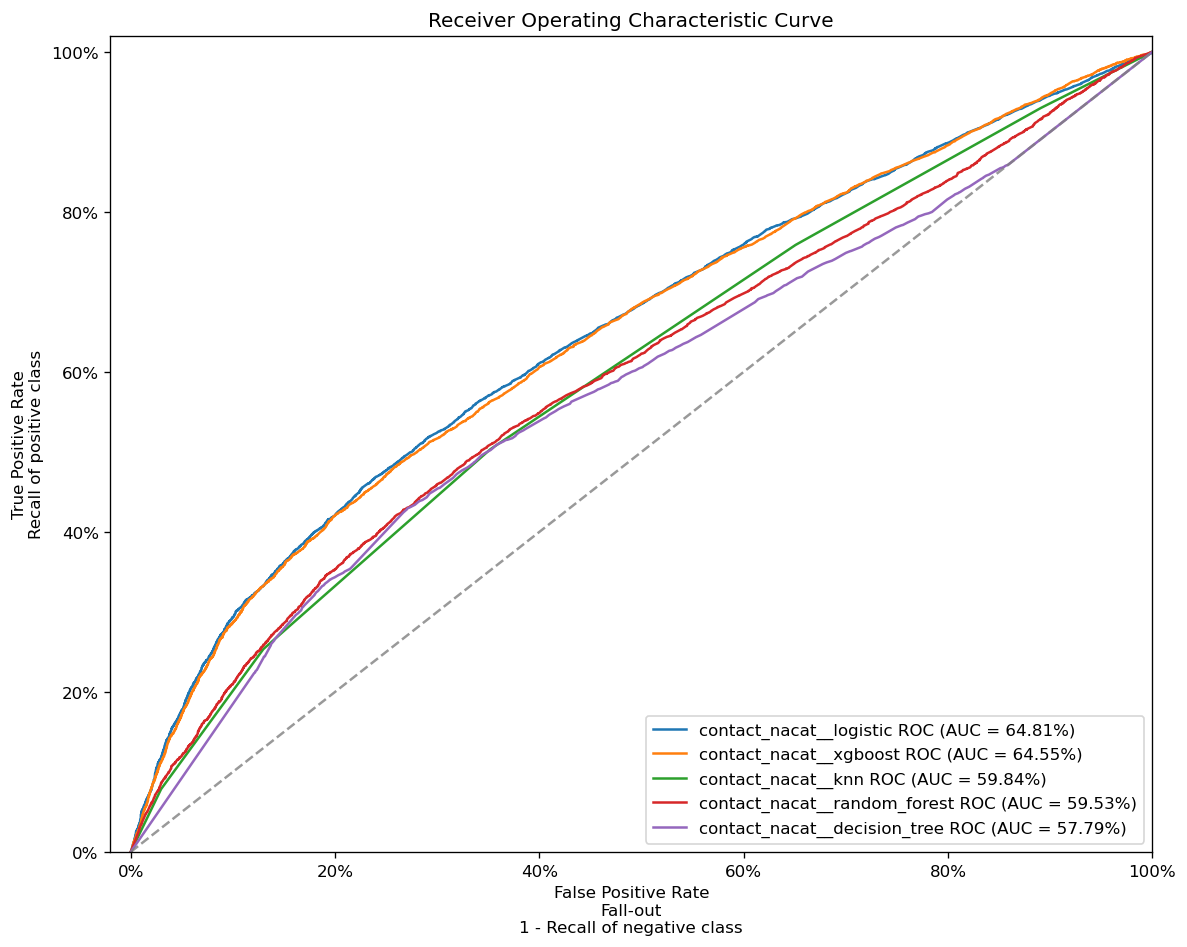

In [48]:
model_ranks = {}
for preproc_name, tts in tts_tuples.items():

    clfs_preproc = { full_name: clf for full_name, clf in clfs.items() if full_name.startswith(preproc_name) }

    model_ranks[preproc_name] = splt.plot_roc_auc_curve(
        models = clfs_preproc,
        X_test = tts[1], y_test = tts[3],
    )

In [52]:
model_rank_all = (
    pd.concat(
        [ model_rank for model_rank in model_ranks.values() ]
    )
    .sort_values(by = 'brier', ascending = True)
)
model_rank_all

,model,auroc,brier,logloss,f1,precision,recall,accuracy
model_name,,,,,,,,
contact_dropna__logistic,"(ColumnTransformer(transformers=[('numericas',...",0.632687,0.225577,0.643193,0.36483,0.646737,0.254079,0.643188
contact_dropna__xgboost,"(ColumnTransformer(transformers=[('numericas',...",0.623905,0.228032,0.65171,0.388052,0.622574,0.281872,0.641452
contact_nacat__logistic,"(ColumnTransformer(transformers=[('numericas',...",0.64806,0.228138,0.64864,0.484353,0.643928,0.388161,0.6342
contact_nacat__xgboost,"(ColumnTransformer(transformers=[('numericas',...",0.645485,0.229957,0.654691,0.495861,0.628621,0.409399,0.63155
contact_dropna__random_forest,"(ColumnTransformer(transformers=[('numericas',...",0.583523,0.253582,0.972726,0.386083,0.549884,0.297472,0.618455
contact_nacat__random_forest,"(ColumnTransformer(transformers=[('numericas',...",0.595276,0.261758,1.009263,0.467605,0.566967,0.397876,0.599
contact_dropna__knn,"(ColumnTransformer(transformers=[('numericas',...",0.585543,0.264692,2.094877,0.450967,0.49236,0.415994,0.591481
contact_nacat__knn,"(ColumnTransformer(transformers=[('numericas',...",0.598424,0.269838,2.259883,0.517147,0.531679,0.503389,0.58395
contact_dropna__decision_tree,"(ColumnTransformer(transformers=[('numericas',...",0.567756,0.283655,4.288457,0.356702,0.549217,0.26412,0.61578


Independentemente da estratégia de pré-processamento, **os modelos de regressão logística e *XGBoost* performaram melhor que os outros**.

O AUROC dos dois está acima de 63%, enquanto que os outros estão abaixo de 60%.

Além disso, a calibragem de probabilidades dos dois modelos está significativamente melhor que os outros. O *Brier score* dos dois está por volta de 0.22, enquanto que o dos outros está acima de 0.25 (menor é melhor). A *logloss* está abaixo de 0.65, enquanto que a dos outros está acima de 0.97.

A respeito da escolha da estratégia de pré-processamento, ainda não temos um vencedor claro. O AUROC dos dois modelos com estratégia pré-processamento `contact_nacat` (codificar os `NaN`s como uma categoria adicional) levam ligeira vantagem no AUROC, mas a calibragem de probabilidades está ligeiramente melhor na estratégia `contact_dropna` (eliminar os registros em que `contact_other_covid` está faltando).